In [1]:
import pandas as pd

df=pd.read_csv("data/elec_cnsmp_data.csv")
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [2]:
df.set_index("DateTime", inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


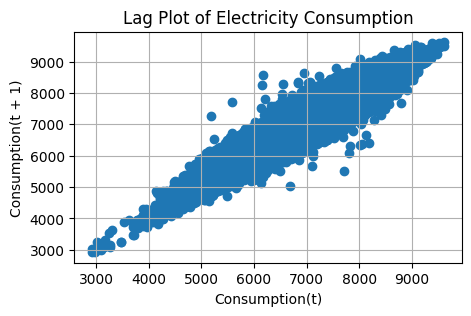

In [6]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

plt.figure(figsize=(5, 3))
lag_plot(df['Consumption'])
plt.title('Lag Plot of Electricity Consumption')
plt.xlabel('Consumption(t)')
plt.ylabel('Consumption(t + 1)')
plt.grid(True)
plt.show()

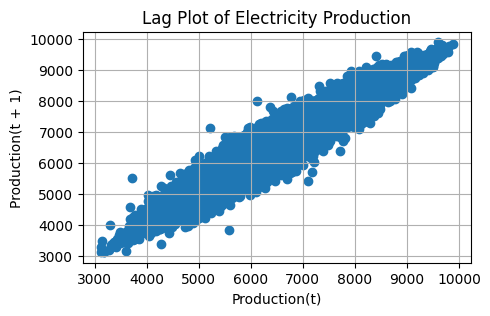

In [7]:
plt.figure(figsize=(5, 3))
lag_plot(df['Production'])
plt.title('Lag Plot of Electricity Production')
plt.xlabel('Production(t)')
plt.ylabel('Production(t + 1)')
plt.grid(True)
plt.show()

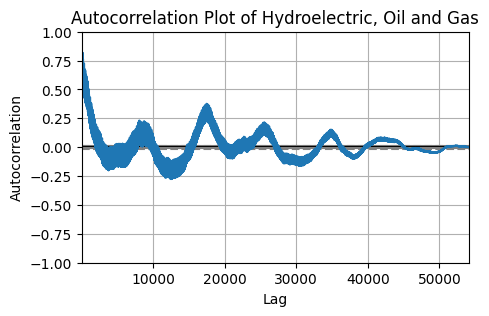

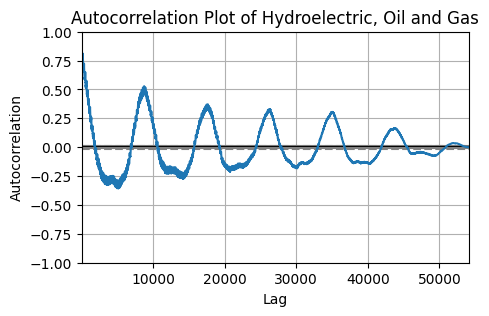

In [8]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(5, 3))
autocorrelation_plot(df['Hydroelectric'])
plt.title('Autocorrelation Plot of Hydroelectric, Oil and Gas')
plt.grid(True)
plt.show()
plt.figure(figsize=(5, 3))
autocorrelation_plot(df['Oil and Gas'])
plt.title('Autocorrelation Plot of Hydroelectric, Oil and Gas')
plt.grid(True)
plt.show()

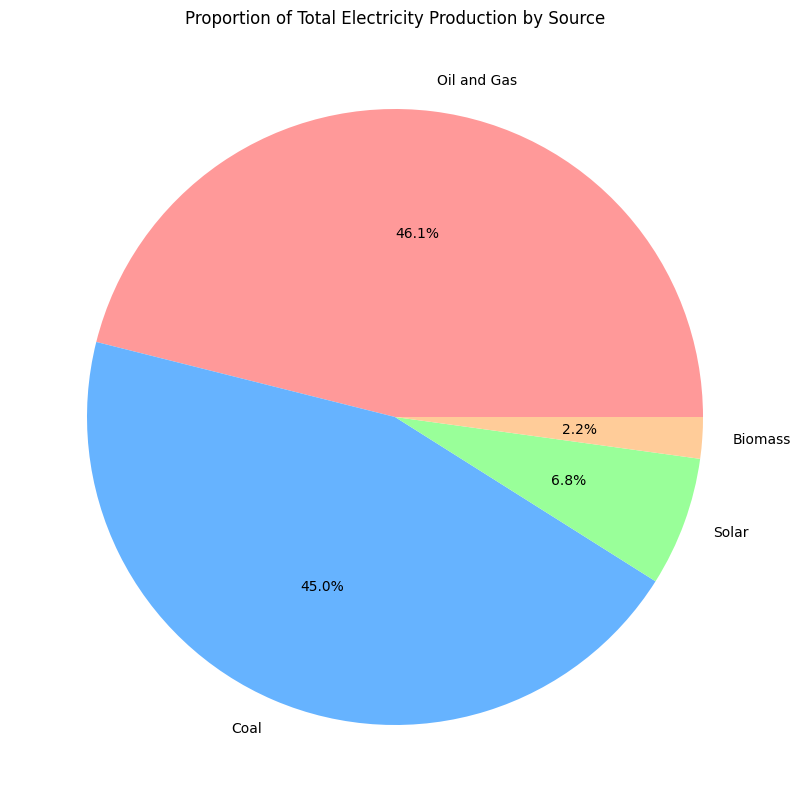

In [9]:
energy_sources = ['Oil and Gas', 'Coal', 'Solar', 'Biomass']

total_production_by_source = df[energy_sources].sum()

plt.figure(figsize=(10, 10))
total_production_by_source.plot(kind='pie', autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#c4e17f'])

plt.ylabel('')
plt.title('Proportion of Total Electricity Production by Source')
plt.show()

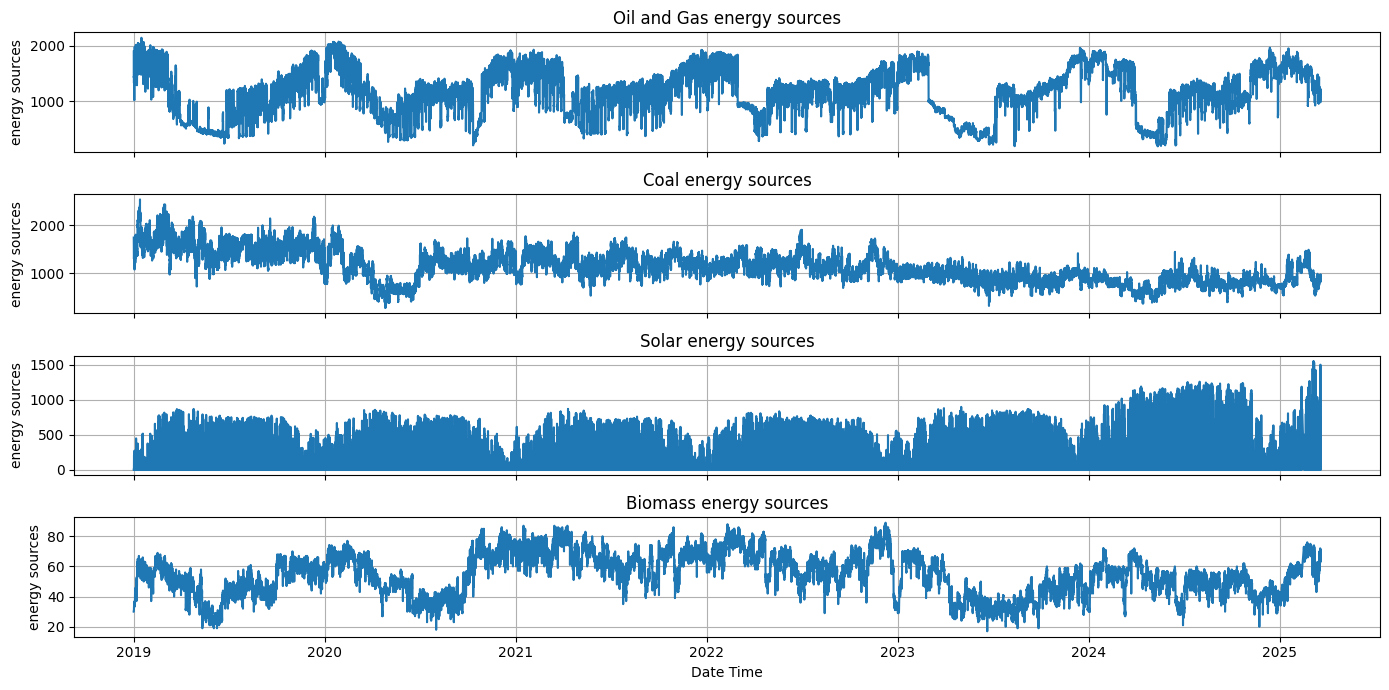

In [10]:
fig, axes = plt.subplots(nrows=len(energy_sources), ncols=1, figsize=(14, 7), sharex=True)

# Plot each energy source in its own subplot
for i, source in enumerate(energy_sources):
    axes[i].plot(df.index, df[source], label=source)
    axes[i].set_ylabel('energy sources')
    axes[i].set_title(f'{source} energy sources')
    axes[i].grid(True)

# Set common x-axis label and adjust layout
plt.xlabel('Date Time')
plt.tight_layout()
plt.show()

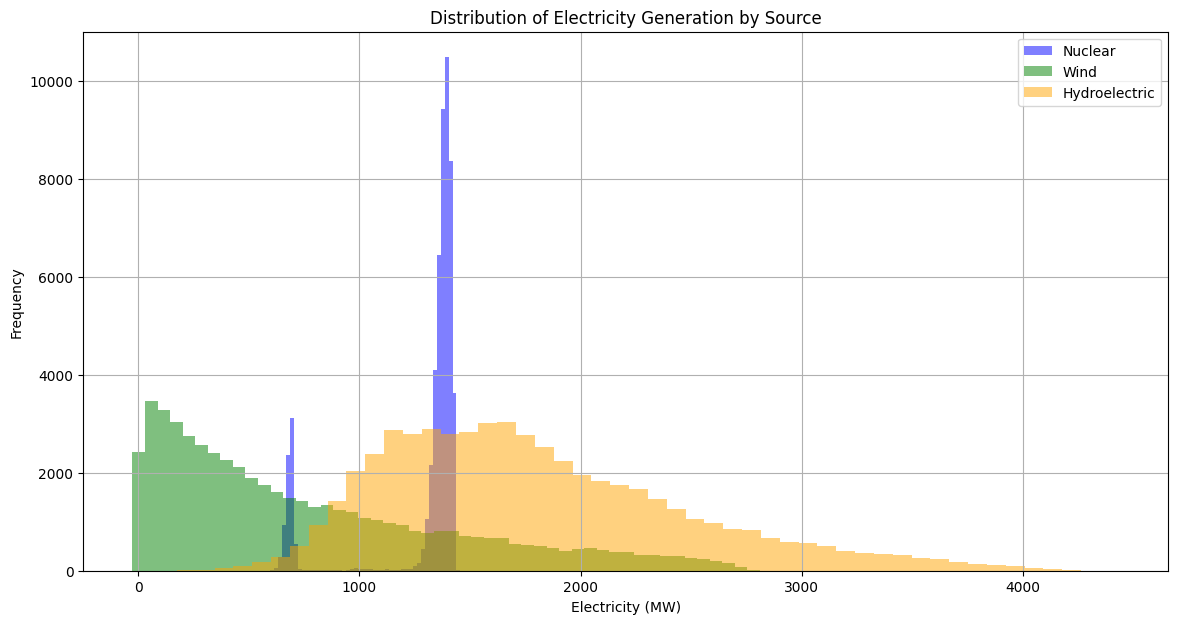

In [11]:
plt.figure(figsize=(14, 7))

plt.hist(df['Nuclear'], bins=50, alpha=0.5, label='Nuclear', color='blue')
plt.hist(df['Wind'], bins=50, alpha=0.5, label='Wind', color='green')
plt.hist(df['Hydroelectric'], bins=50, alpha=0.5, label='Hydroelectric', color='orange')

plt.xlabel('Electricity (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Generation by Source')
plt.legend()
plt.grid(True)
plt.show()

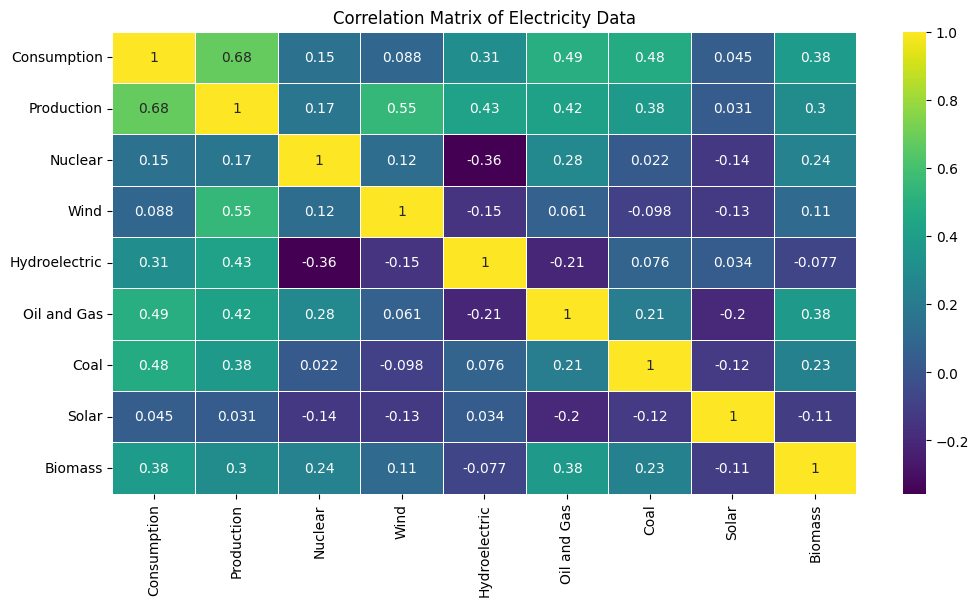

In [12]:
import seaborn as sns

plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Electricity Data')
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']])

# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'])

In [14]:
import numpy as np

def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [15]:
SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)


In [18]:
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=32,
    shuffle=False
)

In [ ]:
class SimpleLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=50):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        return self.fc(x)

In [ ]:
rnn_model = SimpleLSTMRegressor(input_size=X_train.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)


In [21]:
from tqdm import tqdm

epochs = 20
rnn_history = {'train_loss': []}

rnn_model.train()
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = rnn_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    rnn_history['train_loss'].append(epoch_loss)
    print(f'Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_loss:.6f}')

  5%|▌         | 1/20 [00:08<02:41,  8.49s/it]

Epoch [1/20] - Train Loss: 0.005160


 10%|█         | 2/20 [00:28<04:30, 15.05s/it]

Epoch [2/20] - Train Loss: 0.001028


 15%|█▌        | 3/20 [00:52<05:26, 19.23s/it]

Epoch [3/20] - Train Loss: 0.000676


 20%|██        | 4/20 [01:17<05:42, 21.40s/it]

Epoch [4/20] - Train Loss: 0.000671


 25%|██▌       | 5/20 [01:38<05:23, 21.54s/it]

Epoch [5/20] - Train Loss: 0.000617


 30%|███       | 6/20 [02:01<05:06, 21.88s/it]

Epoch [6/20] - Train Loss: 0.000522


 35%|███▌      | 7/20 [02:29<05:10, 23.89s/it]

Epoch [7/20] - Train Loss: 0.000428


 40%|████      | 8/20 [02:56<05:00, 25.05s/it]

Epoch [8/20] - Train Loss: 0.000397


 45%|████▌     | 9/20 [03:25<04:46, 26.02s/it]

Epoch [9/20] - Train Loss: 0.000391


 50%|█████     | 10/20 [03:49<04:16, 25.62s/it]

Epoch [10/20] - Train Loss: 0.000378


 55%|█████▌    | 11/20 [04:10<03:36, 24.06s/it]

Epoch [11/20] - Train Loss: 0.000363


 60%|██████    | 12/20 [04:29<03:01, 22.71s/it]

Epoch [12/20] - Train Loss: 0.000352


 65%|██████▌   | 13/20 [04:49<02:32, 21.85s/it]

Epoch [13/20] - Train Loss: 0.000339


 70%|███████   | 14/20 [05:06<02:02, 20.40s/it]

Epoch [14/20] - Train Loss: 0.000325


 75%|███████▌  | 15/20 [05:26<01:41, 20.22s/it]

Epoch [15/20] - Train Loss: 0.000316


 80%|████████  | 16/20 [05:48<01:23, 20.79s/it]

Epoch [16/20] - Train Loss: 0.000311


 85%|████████▌ | 17/20 [06:10<01:03, 21.21s/it]

Epoch [17/20] - Train Loss: 0.000304


 90%|█████████ | 18/20 [06:31<00:41, 20.99s/it]

Epoch [18/20] - Train Loss: 0.000297


 95%|█████████▌| 19/20 [06:59<00:23, 23.18s/it]

Epoch [19/20] - Train Loss: 0.000291


100%|██████████| 20/20 [07:27<00:00, 22.38s/it]

Epoch [20/20] - Train Loss: 0.000285


In [ ]:
rnn_model.eval()
with torch.no_grad():
    rnn_predictions = rnn_model(X_test_t.to(device)).cpu().numpy().flatten()

rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)

print(f'PyTorch LSTM - R² Score: {rnn_r2}')
print(f'PyTorch LSTM - Mean Absolute Error (MAE): {rnn_mae}')
print(f'PyTorch LSTM - Mean Squared Error (MSE): {rnn_mse}')
print(f'PyTorch LSTM - Root Mean Squared Error (RMSE): {rnn_rmse}')

PyTorch Simple RNN - R² Score: 0.9655310881002197
PyTorch Simple RNN - Mean Absolute Error (MAE): 0.019239601569996243
PyTorch Simple RNN - Mean Squared Error (MSE): 0.0007838088901256138
PyTorch Simple RNN - Root Mean Squared Error (RMSE): 0.027996587115675615
